# 90°剥離試験の解析


 90dC_w_heatgun 
        0       1        2        3
0   0.00  25.480  113.820  166.630
1  54.79  86.590  166.690  132.690
2   4.49   0.475   11.478    4.573
[0.         0.12980228 0.32564667 0.21530039]


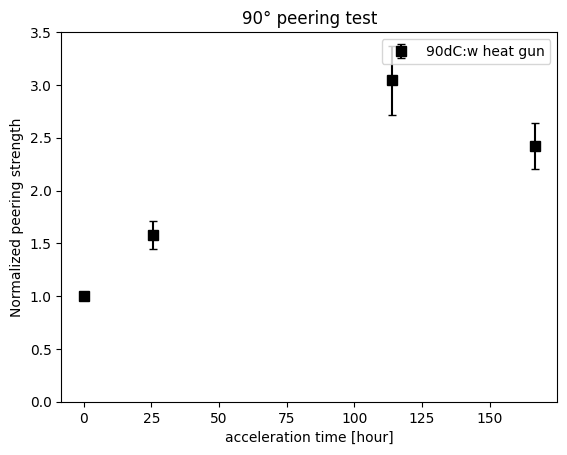

In [7]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#
#T_accel =['70dC_wo_heatgun','80dC','90dC_w_heatgun']
#fig, ax = plt.subplots()
#colors = ['black','green','blue','red']
#ntemp = T_accel.__len__()
#label_list = ['70dC:w/o heat gun' ,'80dC' ,'90dC:w heat gun','98']
#
#for itemp in range(ntemp):
#	temp_accel = T_accel[itemp]
#	filename = f'./peeringArchiveDir/peering_{temp_accel}.csv'
#	df = pd.read_csv(filename,sep="\t"
#									 ,skiprows=1
#									 #,names=['1','2','3','4']
#									 ,header=None
#									 )
#	print("\n",temp_accel,"\n",df)
#	#weight_dataset = df.to_numpy()
#	#t_accel = weight_dataset[0]
#	#weight_break = weight_dataset[1]
#	#weight_err = weight_dataset[2]
#	#ax.errorbar(t_accel, weight_break, yerr=weight_err, capsize=3, fmt='s'
#	#            , ecolor=colors[itemp], color=colors[itemp],ms=7, mec='k'
#	#            , label=label_list[itemp])
#
#	weight_dataset = df.to_numpy()
#	t_accel = weight_dataset[0]
#	initialBreakingWeight = weight_dataset[1][0]
#	initialBreakingWeightErr = weight_dataset[2][0]
#	breakingWeightRatio = weight_dataset[1]/initialBreakingWeight
#	weightRatioErr = breakingWeightRatio*np.sqrt(np.square(weight_dataset[2]/weight_dataset[1])+np.square(initialBreakingWeightErr/initialBreakingWeight))
#	weightRatioErr[0] = 0
#	print(weightRatioErr)
#	ax.errorbar(t_accel, breakingWeightRatio, yerr=weightRatioErr, capsize=3, fmt='s'
#				, ecolor=colors[itemp], color=colors[itemp],ms=7, mec='k'
#				, label=label_list[itemp])
#
#ax.set_xlabel('acceleration time [hour]')
##ax.set_ylabel('adhesive power [g]')
#ax.set_ylabel('Normalized peering strength')
##plt.yscale('log')
#plt.legend(loc='upper right')
#ax.set_title('90° peering test')
#plt.ylim([0,3.5])
#plt.show()


## 設計変更

スプレッドシート：オフセット補正＋経過時間の計算\
以下Python			：DataFrameの作成＋統計量（平均と誤差率）の計算\
まずは、こんなcsvを手でつくる

header[90dC] \
time1			time2\
weight1-1	weight2-1	\
weigth1-2	weigth2-2	\
weigth1-3	weigth2-3	\
weigth1-4	weigth2-4	\ 

read_csvをして、各行ごとの「時間・平均・サンプル数」を別のdfに詰める。\
それとは別に分散(率)を計算し、全ての測定を利用した誤差率を計算する。\
標準誤差を計算してerrorbar付きプロット

   70dC_wo_heatgun  sample1  sample2  sample3  sample4
0             0.00   55.100    67.80   77.100   72.400
1            30.07   56.780    60.09   64.415   66.935
2            72.57   57.555    60.90   57.555   45.335
3           143.70   93.450    81.96   98.450  107.780
4           196.62   58.380    47.14   87.230   89.730
     80dC  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
0    0.00      200.64     207.545     194.165     211.515         NaN
1   58.70      117.67     120.140     124.670     116.640         NaN
2  107.07      118.32     120.430     125.020     116.920         NaN
3  325.23       98.02      95.420      90.020     110.420         NaN
     90dC  #誤差率を求める時には最初の加速前の行を消す。  Unnamed: 2  Unnamed: 3  Unnamed: 4
0    0.00                   200.64     207.545     194.165     211.515
1   25.17                    68.02      60.420      75.020      70.420
2  522.98                    75.02      90.420      98.020      90.420
3  498.90                   125.02  

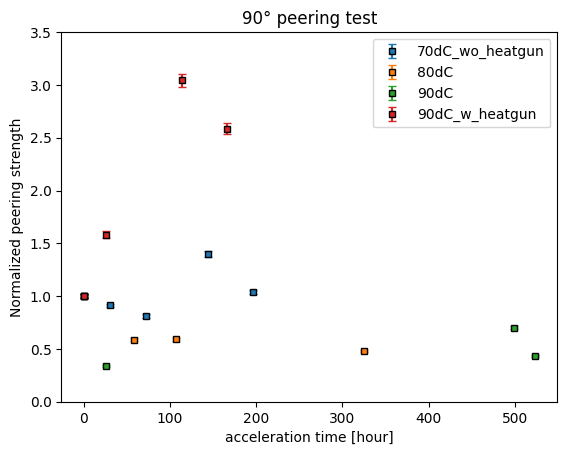

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob as glob

fig, ax = plt.subplots()
colors = ['blue','green','red','brown']
errlist = [0.01394836*np.sqrt(2),0.00691378*np.sqrt(2)]#比の値について誤差の伝播則よりsqrt(2)が必要
Rerr =errlist[0]

csv_files = sorted(glob.glob('peeringTable_*.csv'))

for itemp,file in enumerate(csv_files):
	df = pd.read_csv(file,sep="\t"
									 )
	print(df)
	temp_accel=df.columns.values[0]
	t_accel=df.iloc[:,0].to_numpy()
	weightMean=df.iloc[:,1:].mean(axis='columns').to_numpy()
	normalizedWight = weightMean/weightMean[0]
	ax.errorbar(t_accel,normalizedWight,yerr=normalizedWight*Rerr
						 , capsize=3
						 , fmt='s'
						 #, ecolor=colors[itemp], color=colors[itemp]
						 ,ms=5, mec='k'
						 , label=temp_accel)

ax.set_xlabel('acceleration time [hour]')
ax.set_ylabel('Normalized peering strength')
#plt.yscale('log')
plt.legend(loc='upper right')
ax.set_title('90° peering test')
plt.ylim([0,3.5])
plt.show()

## 分散から誤差率の計算

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob as glob

typeOfTest=['peering','shearing']
csv_files = sorted(glob.glob(typeOfTest[1]+'Table_*.csv'))

numerator=[0]
denominator=[0]
for itemp,file in enumerate(csv_files):
	df = pd.read_csv(file,sep="\t")
	df_weight = df.iloc[:,1:]
	print("df = ",df)
	#print("df_weight = ",df_weight)
	nsampleArray = df_weight.count(axis=1).to_numpy()
	print("nsampleArray = ",nsampleArray)
	weightMean=df_weight.mean(axis='columns').to_numpy()
	weightVariance=df_weight.var(axis='columns',ddof=1).to_numpy()
	weightVarianceRate = weightVariance/weightMean
	print("weightMean = ",weightMean)
	print("weightVariance = ",weightVariance)
	print("weightVarianceRate= ",weightVarianceRate)

	numerator += ((nsampleArray-1)/(2*weightVarianceRate)).sum()
	denominator += ((nsampleArray-1)/(2*np.square(weightVarianceRate))).sum()
print(numerator/denominator)

df =     70dC_wo_heatgun  sample1  sample2  sample3  sample4  Unnamed: 5  Unnamed: 6
0             0.00    4.225    5.335    5.405    5.655         NaN         NaN
1            30.07    4.885    5.135      NaN      NaN         NaN         NaN
2            96.58    5.875    5.520    5.725    5.980         NaN         NaN
3           140.92    5.300    5.700    5.415    5.815         NaN         NaN
4           196.62    5.775    5.655    4.855    4.705       4.125       4.715
nsampleArray =  [4 2 4 4 6]
weightMean =  [5.155      5.01       5.775      5.5575     4.97166667]
weightVariance =  [0.40326667 0.03125    0.03985    0.05774167 0.39594667]
weightVarianceRate=  [0.07822826 0.00623752 0.00690043 0.01038986 0.07964063]
df =       80dC  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
0    0.00       8.420        7.77       8.310       8.020         NaN
1   58.70       4.845        5.00       5.245       6.105         NaN
2  107.07       5.290        5.20       5.075       